In [1]:
#!python prepare_data_spleen.py

In [2]:
from cnn.model import build_net
from spleen_dataset.dataloader import SpleenDataloader, SpleenDataset, get_training_augmentation, get_validation_augmentation
from spleen_dataset.config import dataset_folder
from spleen_dataset.utils import get_split_deterministic, get_list_of_patients
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import random

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
#   except RuntimeError as e:
#     print(e)

2022-11-19 10:12:06.358625: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-19 10:12:08.028102: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-19 10:12:08.033178: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-19 10:12:08.062703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 10:12:08.062798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.75GiB deviceMemoryBandwidth: 335.32GiB/s
2022-11-19 10:12:08.062812: I tensorflow/stream_executor/platform/d

In [3]:
gpus

[]

In [4]:
data_path = './data/Task09_Spleen_2D'

patch_size = (128, 128)
batch_size = 32
num_classes = 2
skip_slices = 1
stem_filters = 16
max_depth = 4

augmentation = get_training_augmentation(patch_size)

/home/guilherme/git/segqnas/.venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [5]:
patients = get_list_of_patients(dataset_folder)
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

train_patients, val_patients = get_split_deterministic(patients, fold=1, num_splits=5, random_state=0)

train_dataset = SpleenDataset(train_patients, only_non_empty_slices=True, skip_slices=skip_slices)
val_dataset = SpleenDataset(val_patients, only_non_empty_slices=True)

train_dataloader = SpleenDataloader(train_dataset, batch_size, train_augmentation)
val_dataloader = SpleenDataloader(val_dataset, batch_size, val_augmentation)

In [6]:
len(train_dataset)

430

In [7]:
len(train_dataloader)

13

(512, 512)
(512, 512)


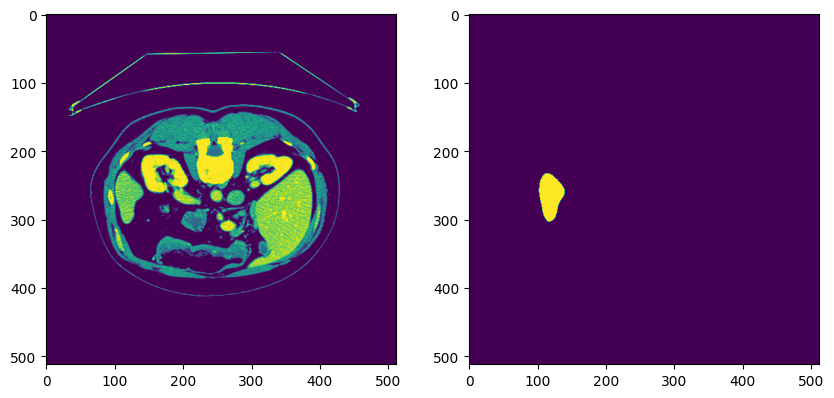

In [8]:
id = random.randint(0, len(train_dataset))
image, label = train_dataset[id]

print(image.shape)
print(label.shape)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(label)

(128, 128)
(128, 128)


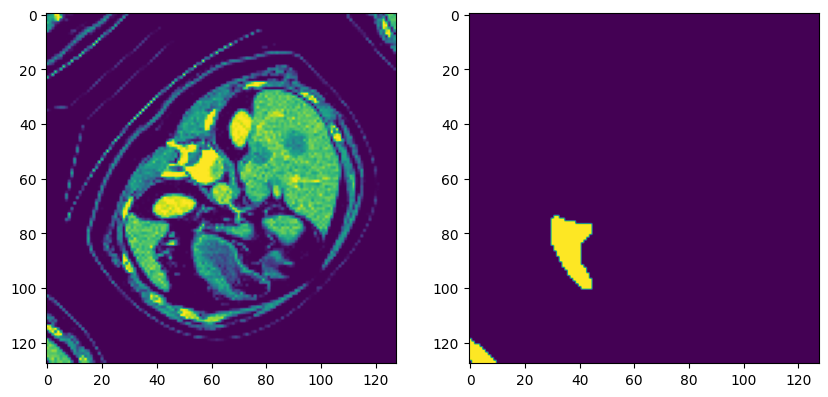

In [9]:
id = random.randint(0, len(train_dataloader))
images, labels = train_dataloader[id]

image = images[0]
label =labels[0]

print(image.shape)
print(label.shape)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(image)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(label)

In [10]:
net_list = [
    'down_vgg_3', 
    'down_vgg_3',
    'down_vgg_3',
    'down_vgg_3',
    'non_vgg_3',
    'up_vgg_3',
    'up_vgg_3',
    'up_vgg_3',
    'up_vgg_3'
]

fn_dict = {
    'down_vgg_3': {'cell': 'DownscalingCell', 'block': 'VGGBlock', 'kernel': 3, 'prob': 1/3},
    'up_vgg_3':   {'cell': 'UpscalingCell',   'block': 'VGGBlock', 'kernel': 3, 'prob': 1/3},
    'non_vgg_3':  {'cell': 'NonscalingCell',  'block': 'VGGBlock', 'kernel': 3, 'prob': 1/3},
}

In [11]:
model = build_net((*patch_size, 1), stem_filters, max_depth, num_classes, fn_dict, net_list)
model.summary()

2022-11-19 10:12:42.554632: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-19 10:12:42.554670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-19 10:12:42.554677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      


Model: "net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
StemConvolution_Convolution_Con (None, 128, 128, 16) 144         input[0][0]                      
__________________________________________________________________________________________________
StemConvolution_Normalization_N (None, 128, 128, 16) 64          StemConvolution_Convolution_Convo
__________________________________________________________________________________________________
StemConvolution_Activation_ReLU (None, 128, 128, 16) 0           StemConvolution_Normalization_Nor
________________________________________________________________________________________________

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


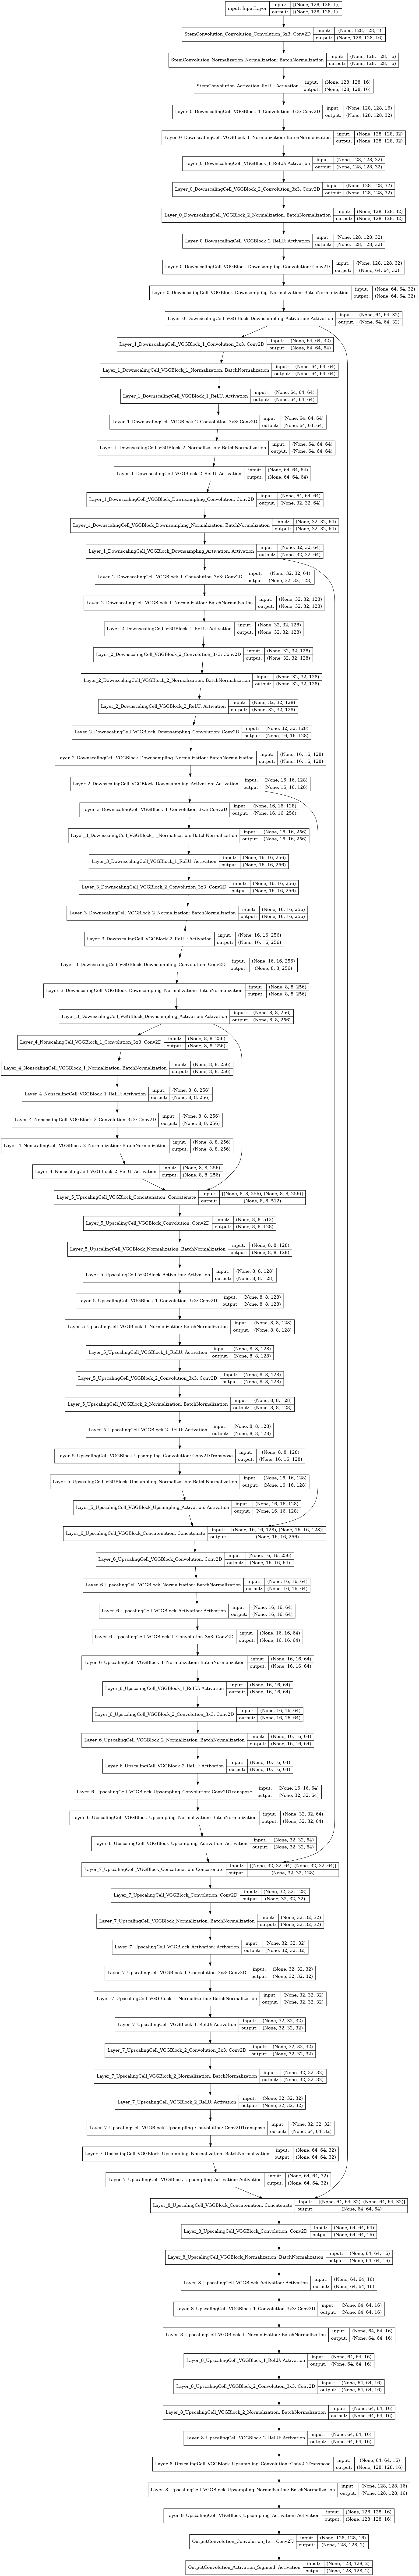

In [12]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           rankdir='TB'
            )
Image('model.png')

In [13]:
history = model.fit(
    train_dataloader,
    validation_data=val_dataloader,
    epochs=50,
    callbacks=[
        EarlyStopping(
            monitor="val_loss", mode="min", verbose=1, patience=5
        ),
        # ModelCheckpoint(
        #     "best_model.h5",
        #     save_best_only=True,
        #     monitor="val_loss",
        #     mode="min",
        # ),
        # TensorBoard(log_dir="./logs")
    ],
)

2022-11-19 10:12:43.221323: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-19 10:12:43.240140: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2899885000 Hz


Epoch 1/50


2022-11-19 10:12:45.650709: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.
2022-11-19 10:12:45.685759: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 33554432 exceeds 10% of free system memory.
2022-11-19 10:12:45.703283: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67108864 exceeds 10% of free system memory.
2022-11-19 10:12:45.729039: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67108864 exceeds 10% of free system memory.
2022-11-19 10:12:45.763597: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 67108864 exceeds 10% of free system memory.


13/13 [==============================] - 32s 2s/step - loss: 0.9682 - gen_dice_coef: 0.0383 - soft_gen_dice_coef: 0.0377 - val_loss: 0.9476 - val_gen_dice_coef: 0.0633 - val_soft_gen_dice_coef: 0.0583
Epoch 2/50
13/13 [==============================] - 29s 2s/step - loss: 0.9518 - gen_dice_coef: 0.0619 - soft_gen_dice_coef: 0.0541 - val_loss: 0.9285 - val_gen_dice_coef: 0.1103 - val_soft_gen_dice_coef: 0.0775
Epoch 3/50
13/13 [==============================] - 29s 2s/step - loss: 0.9309 - gen_dice_coef: 0.1259 - soft_gen_dice_coef: 0.0751 - val_loss: 0.9084 - val_gen_dice_coef: 0.1971 - val_soft_gen_dice_coef: 0.0976
Epoch 4/50
13/13 [==============================] - 28s 2s/step - loss: 0.9084 - gen_dice_coef: 0.2401 - soft_gen_dice_coef: 0.0976 - val_loss: 0.8859 - val_gen_dice_coef: 0.2903 - val_soft_gen_dice_coef: 0.1200
Epoch 5/50
13/13 [==============================] - 30s 2s/step - loss: 0.8840 - gen_dice_coef: 0.3459 - soft_gen_dice_coef: 0.1219 - val_loss: 0.8582 - val_gen_di

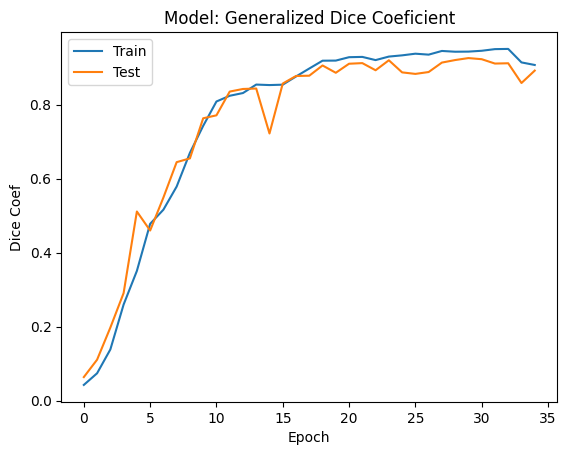

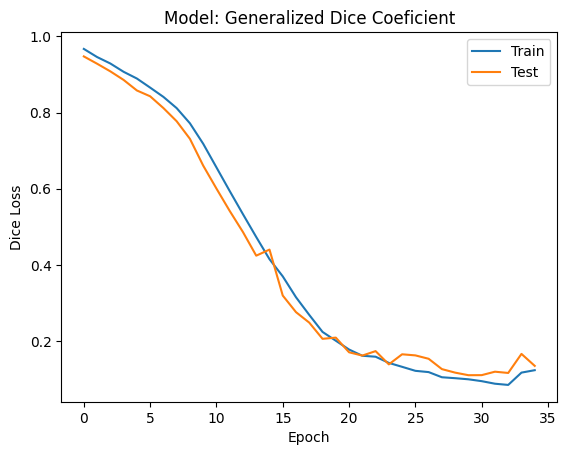

In [14]:
# plotting the dice coeff results (accuracy) as a function of the number of epochs
plt.figure()
plt.plot(history.history['gen_dice_coef'])
plt.plot(history.history['val_gen_dice_coef'])
plt.title('Model: Generalized Dice Coeficient')
plt.ylabel('Dice Coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plotting the dice coeff results (loss function) as a function of the number of epochs
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model: Generalized Dice Coeficient')
plt.ylabel('Dice Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [15]:
!tensorboard --logdir='./logs'

2022-11-19 10:30:23.122344: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.11.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
